In [1]:
import osmnx as ox
import momepy
import geopandas as gpd
import networkx
from osmnx import io
from geopandas import GeoDataFrame, GeoSeries
from centerline.geometry import Centerline
path ='output'
project_crs = 'epsg:3857'
import pandas as pd
import ast
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon,Point,LineString,MultiPolygon

### Run only when download for first time

In [7]:
# Create graph from OSM server and project it
graph = ox.graph_from_place('Torino', network_type='all')
graph  = ox.bearing.add_edge_bearings(graph, precision=1)
graph_pro = ox.projection.project_graph(graph, to_crs=project_crs)
io.save_graph_geopackage(graph_pro, filepath='.', encoding='utf-8', directed=False)

### End

In [1]:
# delete segments without names
my_gdf = gpd.read_file(f'{path}/edges.shp')
not_null= my_gdf.dropna(subset='name')
not_null.to_file(f'{path}/not_null.shp')

NameError: name 'gpd' is not defined

In [73]:
# delete segments present any kind of roundabout or tunnel
not_roundaout = not_null[~((not_null['junction']=='roundabout')|(not_null['junction']=='circular')|(not_null['tunnel']=='building_passage')|(not_null['tunnel']=='yes')| (not_null['highway']=='cycleway')| (not_null['highway']=='path'))]
not_roundaout.to_file(f'{path}/not_roundabout_tunnel.shp')

In [75]:
# Project dataframe and calculate angle (0 to 180)
df_pro = not_roundaout.to_crs(project_crs)
df_pro['angle'] = df_pro['bearing'].apply(lambda x:x if x<180 else x-180)
df_pro.to_file(f'{path}/pro.shp')

In [ ]:
# only the first value will be saed highway with more than 1 value

In [2]:
def length_of_parallel(my_s_join: GeoDataFrame, the_buffer:GeoSeries, geo_field:str)-> int:
    my_s_join['geometry'] =my_s_join[geo_field]
    new_data_0 = my_s_join.sjoin(GeoDataFrame(geometry=the_buffer, crs= project_crs), how='inner').reset_index()
    if len(new_data_0)==0:
        return 0
    return len(new_data_0[new_data_0['index']!= new_data_0['index_right']])

In [9]:
def check_parallelism(to_translate: GeoDataFrame, is_test:bool=False)->bool:
    my_buffer = to_translate['geometry'].buffer(cap_style=2, distance=30, join_style=3)
    to_translate['geometry_right'] = to_translate['geometry'].apply(lambda x:x.parallel_offset(35, 'right'))
    to_translate['geometry_left'] = to_translate['geometry'].apply(lambda x:x.parallel_offset(35, 'left'))
    # Currently is it not working
    if is_test:
        # to_translate.drop(columns= ['geometry', new_geometry[0]]).rename(columns = {new_geometry[1]: 'geometry'}).to_file(f'{path}/test_data/res_translate_{new_geometry[1]}.shp')
        # to_translate.drop(columns= ['geometry', new_geometry[1]]).rename(columns = {new_geometry[0]: 'geometry'}).to_file(f'{path}/test_data/res_translate_{new_geometry[0]}.shp')
        my_buffer.to_file(f'{path}/test_data/buffers_test.shp')
    if length_of_parallel(to_translate, my_buffer, 'geometry_right') >0 or length_of_parallel(to_translate, my_buffer, 'geometry_left') >0:
        return True
    else:
        return False

In [62]:
def simplify(my_polygon:Polygon,x:(int,float))-> Polygon:
    simplify_poly = my_polygon.simplify(x, preserve_topology=False)
    if simplify_poly.area<50:
        simplify_poly= simplify(my_polygon,x/2)
    return simplify_poly

In [132]:
def create_center_line():
    """
    This method calculate new line between the farthest points of the simplified polygon
    :param one_poly:
    :return:
    """
    one_poly = simplify(polygon, 100)
    pnt_list = one_poly.exterior.coords[:-1]
    list_shp = [Point(item) for item in pnt_list]
    dis = 0
    max_dis = (-1, -1)
    # The new line will be determined by the farthest points
    for i, point in enumerate(list_shp):
        j = i
        for point2 in list_shp[i + 1:]:
            j += 1
            if point.distance(point2) > dis:
                max_dis = (i, j)
                dis = point.distance(point2)
    if is_test:
        dic_sim = {'index':[0],'geometry':one_poly}
        GeoDataFrame(dic_sim,crs='epsg:3857').to_file(f'{path}/test_data/simplify_poly_{unit[0]}_{id_pol + 2}.shp')
    max_dist['name'].extend([id_pol + 2, id_pol + 2])
    max_dist['geometry'].extend([list_shp[max_dis[0]], list_shp[max_dis[1]]])

In [121]:
def update_df_with_center_line(new_line):
    """
    update our dictionary with new lines
    :param new_line:
    :return:
    """
    dic_final['name'].append(name)
    # dic_final['geometry'].append(LineString(coordinates=(pnt_list[max_dis[0]], pnt_list[max_dis[1]])))
    dic_final['geometry'].append(new_line)
    dic_final['highway'].append(data.iloc[0]['highway'])
    dic_final['bearing'].append(data['angle'].mean())
    dic_final['group'].append(unit[0])


In [5]:
df_pro = gpd.read_file((f'{path}/pro.shp'))

In [112]:
def update_list(line):
    """
    add the first start/end point into the list
    :param line:
    :return:
    """
    list_pnts_of_line_group.extend([Point(line.coords[0]), Point(line.coords[-1])])


In [70]:
# Main point to start
is_test = False
my_groupby = df_pro.groupby('name')
dic_final = {'name': [], 'geometry': [], 'highway': [], 'bearing': [],'group':[]}
new_lines = {'name':[],'geometry':[]}
for_time = len(my_groupby)
for i, street in enumerate(my_groupby):
    # Calculate time to run ToDo
    # print(round(i / for_time * 100, 2))
    res = street[1]
    name = street[0]
    # ToDo for test
    name = 'Via Verolengo'
    res = df_pro[df_pro['name']==name]
    ####
    # groupby angle
    res =  res.dropna(subset= ['angle'],axis=0)
    if len(res)==0:
        continue
    res['group'] = DBSCAN(eps=5, min_samples=2).fit(res['angle'].to_numpy().reshape(-1, 1)).labels_
    cur_group = res[res['group'] > -1].groupby('group')
    is_parallel=False
    for group in cur_group:
        data = group[1]
        if check_parallelism(data, is_test=False):
            # if among of lines with same angles some are parallel,find the center line for each group
            is_parallel = True
            for unit in cur_group:
                data = unit[1]
                # new points DataFrame of start/end line of each group
                list_pnts_of_line_group = []
                data['geometry'].apply(update_list)
                df_pnts = GeoDataFrame(geometry=list_pnts_of_line_group,crs='epsg:3857').drop_duplicates()

                # unify lines to one polygon
                buffers = data.buffer(cap_style=3, distance=30, join_style=3)
                one_buffer = buffers.unary_union

                max_dist = {'name':[], 'geometry':[]}
                # simplify polygon with simplify function. If one_buffer is multipolygon object simplify each one them separately
                if isinstance(one_buffer, MultiPolygon):
                    for id_pol, polygon in enumerate(one_buffer):
                       create_center_line()
                else:
                    id_pol =-1
                    create_center_line()
                max_df = GeoDataFrame(max_dist, crs='epsg:3857')
                # find for each points the closet point from the oribinal data. the closet points will create the new line
                s_join = max_df.sjoin_nearest(df_pnts).groupby('name')
                for geo in s_join:
                    same_name =geo[1]
                    if same_name.iloc[0]['index_right'] ==same_name.iloc[1]['index_right']:
                        continue
                    in_0 = same_name.iloc[0]['index_right']
                    in_1 = same_name.iloc[1]['index_right']
                    new_lines['geometry'].append(LineString([df_pnts.loc[in_0]['geometry'],df_pnts.loc[in_1]['geometry']]))
                    new_lines['name'].append(geo[0])

                if is_test:
                    buffers.to_file(f'{path}/test_data/buffers_{unit[0]}.shp')
                    # dic_one = {'index':[0],'geometry':one_buffer.geoms}
                    # GeoDataFrame(dic_one,crs='epsg:3857').to_file(f'{path}/test_data/one_buffer_{unit[0]}.shp')
        # if one group is found as parallel all the groups are calculated as parallel so we don't need to check_parallelism
        GeoDataFrame(new_lines, crs='epsg:3857').to_file(f'{path}/test_data/one_line_manty.shp')
        if is_parallel:
            break

    # ToDo for test
    break


# ToDo for test
# GeoDataFrame(dic_final, crs='epsg:3857').to_file(f'{path}/one_line.shp')
# # create network
# new_network = df_pro[~df_pro['name'].isin(dic_final['name'])][list(dic_final.keys())]
# new_network['is_simplify'] = 0
# simplify = GeoDataFrame(dic_final, crs='epsg:3857')
# simplify['is_simplify'] = 1
# new_network.append(simplify).to_file(f'{path}/new_network.shp')

C:\Users\Achituv\AppData\Local\Temp\ipykernel_33096\1885651142.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for id_pol, polygon in enumerate(one_buffer):
C:\Users\Achituv\AppData\Local\Temp\ipykernel_33096\1885651142.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for id_pol, polygon in enumerate(one_buffer):
C:\Users\Achituv\AppData\Local\Temp\ipykernel_33096\1885651142.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for id_pol, polygon in enumerate(one_buffer):


In [159]:
new_lines = {'name':[],'geometry':[]}
s_join = max_df.sjoin_nearest(df_pnts).groupby('name')
for geo in s_join:
    same_name =geo[1]
    if same_name.iloc[0]['index_right'] ==same_name.iloc[1]['index_right']:
        continue
    in_0 = same_name.iloc[0]['index_right']
    in_1 = same_name.iloc[1]['index_right']
    new_lines['geometry'].append(LineString([df_pnts.loc[in_0]['geometry'],df_pnts.loc[in_1]['geometry']]))
    new_lines['name'].append(geo[0])
GeoDataFrame(new_lines, crs='epsg:3857').to_file(f'{path}/test_data/one_line_updated.shp')

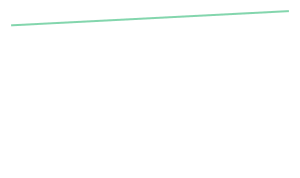

In [157]:
LineString([df_pnts.loc[18]['geometry'],df_pnts.loc[40]['geometry']])

In [156]:
type(df_pnts.loc[18]['geometry'])

shapely.geometry.point.Point